In [1]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from datetime import date

In [2]:
# Import data
file_path = Path("Resources/sp500_adj_close_raw.csv")
df = pd.read_csv(file_path)
df["Date"] = pd.to_datetime(df["Date"])
df.shape
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979679 entries, 0 to 1979678
Data columns (total 14 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Date            datetime64[ns]
 1   Ticker          object        
 2   Adjusted Close  float64       
 3   Return          float64       
 4   Volatility      float64       
 5   RSI             float64       
 6   SMA_50          float64       
 7   SMA_100         float64       
 8   SMA_200         float64       
 9   Upper Band      float64       
 10  Lower Band      float64       
 11  Support         float64       
 12  Resistance      float64       
 13  Action          object        
dtypes: datetime64[ns](1), float64(11), object(2)
memory usage: 211.5+ MB


,Date,Ticker,Adjusted Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance,Action
0,2008-01-02,A,23.256384,-0.009918,0.015705,48.827618,23.314175,23.299887,23.564934,24.727250,22.540232,21.392035,24.351929,short
1,2008-01-02,AAPL,5.876342,0.000462,0.018937,59.067432,5.518483,4.939064,4.197630,6.135834,5.403559,4.637376,6.026839,buy
2,2008-01-02,ABT,18.130205,-0.006092,0.010484,34.677586,18.138458,17.628250,17.709028,19.233109,18.221804,16.775562,19.134010,short
3,2008-01-02,ACGL,7.608889,0.020444,0.016022,45.154190,7.785511,7.878933,7.874161,8.114465,7.378535,7.463333,8.307778,buy
4,2008-01-02,ACN,26.437078,-0.017194,0.024039,54.812183,26.577982,27.784420,28.471031,28.227205,24.273773,24.765505,29.215664,sell


In [3]:
# Drop rows with todays date to remove potentail infill bias
today = date.today()
filter_data_by_date = df["Date"].dt.date == today  # Use .dt.date to compare only the date part

#Create a new DF with todays data
todays_data = df[filter_data_by_date].reset_index(drop=True)
print("Shape:", todays_data.shape)

# Display dataframe
display(todays_data.tail())

Shape: (501, 14)


,Date,Ticker,Adjusted Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance,Action
496,2024-10-23,XYL,131.74,0.002817,0.009287,45.930984,133.56926,134.558320,130.65660,137.970140,131.13087,126.71,137.53000,buy
497,2024-10-23,YUM,134.01,0.004874,0.010931,33.050730,134.76096,133.576890,133.94536,140.494570,130.85544,129.71,139.92000,buy
498,2024-10-23,ZBH,104.68,0.004028,0.010726,51.860280,107.59999,108.161766,115.56048,108.536896,101.40522,101.77,115.91237,buy
499,2024-10-23,ZBRA,368.08,-0.010538,0.009870,55.442924,354.97920,335.774200,309.98975,378.896670,362.71933,320.77,377.68000,short
500,2024-10-23,ZTS,188.99,-0.002744,0.010509,45.437954,189.21500,183.135120,179.39548,196.476970,186.50803,180.90,196.48000,sell


In [4]:
# Create a new DF with historical data (excluding today's data)
historical_data = df[~filter_data_by_date]
df= historical_data
print("Shape:", df.shape)
display(df.tail())

Shape: (1979178, 14)


,Date,Ticker,Adjusted Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance,Action
1979173,2024-10-22,XYL,131.37,0.002817,0.009529,41.234707,133.561680,134.64737,130.55756,137.83467,131.453340,126.71,137.53000,buy
1979174,2024-10-22,YUM,133.36,0.004874,0.012310,22.212175,134.818900,133.60426,133.90901,140.53230,130.725700,129.71,139.92000,buy
1979175,2024-10-22,ZBH,104.26,0.004028,0.010689,44.982456,107.687744,108.26137,115.64309,108.65896,101.441536,101.77,115.91237,buy
1979176,2024-10-22,ZBRA,372.00,-0.010538,0.009591,54.217484,354.260000,335.21680,309.45480,379.07470,362.230320,320.77,377.68000,short
1979177,2024-10-22,ZTS,189.51,-0.002744,0.010508,43.550476,189.202800,182.93680,179.42395,196.46294,186.776060,180.90,196.48000,sell


In [5]:
# Split the data into training and testing sets
# Get the target variable (the "Occupancy" column)
y = df["Return"]#.values.reshape(-1,1)
print("Shape:", y.shape)

Shape: (1979178,)


In [6]:
# Get the features (everything except the "Occupancy" column)
X = df.copy()
X = X.drop(columns=["Return", "Date", "Ticker", "Action"])
print("Shape:", X.shape)

Shape: (1979178, 10)


In [7]:
# Split the data into training and testing sets 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1583342, 10)
Shape of X_test: (395836, 10)
Shape of y_train: (1583342,)
Shape of y_test: (395836,)


In [8]:
# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler()
X_scaler.fit(X_train)

StandardScaler()

In [9]:
# Transform the training and testing data by using the X_scaler model
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

k: 1, Train/Test Score: 1.000/-0.922
k: 3, Train/Test Score: 0.349/-0.310
k: 5, Train/Test Score: 0.210/-0.190
k: 7, Train/Test Score: 0.151/-0.135
k: 9, Train/Test Score: 0.118/-0.105
k: 11, Train/Test Score: 0.097/-0.087
k: 13, Train/Test Score: 0.083/-0.073
k: 15, Train/Test Score: 0.072/-0.063
k: 17, Train/Test Score: 0.064/-0.056
k: 19, Train/Test Score: 0.057/-0.050


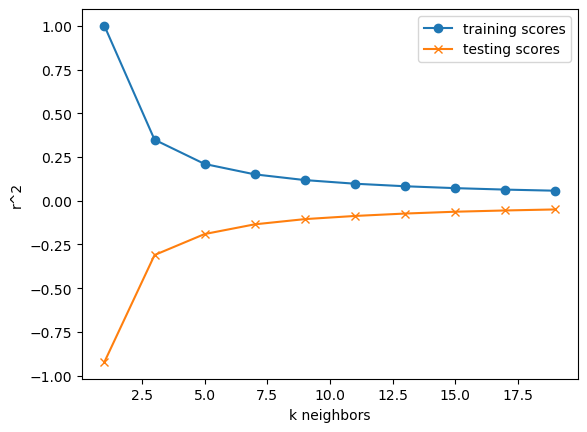

In [13]:
# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
# Plot the results
plt.plot(range(1, 20, 2), train_scores, marker='o', label="training scores")
plt.plot(range(1, 20, 2), test_scores, marker="x", label="testing scores")
plt.xlabel("k neighbors")
plt.ylabel("r^2")
plt.legend()
plt.show()